In [1]:
import random
import string
import re

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

### Parsing the **eng-spa** file

In [2]:
text_file = '/home/antirrabia/Documents/DeepLearning-SETs/spa-eng/spa.txt'

In [3]:
with open(text_file) as f:
    lines = f.read().split('\n')[:-1]
    
text_pairs = []
for line in lines:
    english, spanish = line.split('\t')
    spanish = '[start] ' + spanish + ' [end]'
    text_pairs.append( (english, spanish) )

### Taking a look

In [4]:
print(random.choice(text_pairs))

("It's always a pleasure to see you.", '[start] Siempre es un gusto verte. [end]')


### Getting Training, Validation, and Test Sets

In [5]:
random.shuffle(text_pairs)

num_va_samples = int(0.15 * len( text_pairs ))
num_tr_samples = len(text_pairs) - 2 * num_va_samples

tr_pairs = text_pairs[:num_tr_samples]
va_pairs = text_pairs[num_tr_samples:num_tr_samples + num_va_samples]
te_pairs = text_pairs[num_tr_samples + num_va_samples:]

### TextVectorization layers

In [6]:
# 1 for Eng and 1 for Spa
strip_chars = string.punctuation + '¿'
strip_chars = strip_chars.replace('[', '')
strip_chars = strip_chars.replace(']', '')

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    
    result = tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")
    
    return result

In [7]:
vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)

target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    # we need to offset the spanish sentence by 1
    output_sequence_length=sequence_length + 1, 
    # using our custom standardization function
    standardize=custom_standardization
)

In [8]:
tr_eng_d = [pair[0] for pair in tr_pairs]
tr_spa_d = [pair[1] for pair in tr_pairs]

source_vectorization.adapt(tr_eng_d)
target_vectorization.adapt(tr_spa_d)

In [9]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    
    result = (
        {
            'english': eng,
            'spanish': spa[:, :-1] # spanish sentence does not include the last token to match inputs and targets
        }, spa[:, 1:] # spanish sentence is offset by 1
    )
    
    return result

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset.shuffle(2048).prefetch(16).cache()

In [10]:
tr_d = make_dataset(tr_pairs)
va_d = make_dataset(va_pairs)
te_d = make_dataset(te_pairs)

In [11]:
# taking a look
for inputs, targets in tr_d.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 20)
inputs['spanish'].shape: (64, 20)
targets.shape: (64, 20)


### The model

In [12]:
embed_dim = 256
latent_dim = 1024

strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [13]:
with strategy.scope():
    source = keras.Input(shape=(None,), dtype='int64', name='english')
    
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
    encoded_source = layers.Bidirectional( layers.GRU(latent_dim), merge_mode='sum')(x)
    
    past_target = keras.Input(shape=(None,), dtype='int64', name='spanish')
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
    
    decoder_gru = layers.GRU(latent_dim, return_sequences=True)
    
    x = decoder_gru(x, initial_state=encoded_source)
    
    x = layers.Dropout(0.5)(x)
    
    target_next_step = layers.Dense(vocab_size, activation='softmax')(x)
    
    sequecen2sequence_rnn = keras.Model([source, past_target], target_next_step)
    
    sequecen2sequence_rnn.compile(
        optimizer='rmsprop',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        'sequence2sequence_rnn.keras',
        save_best_only=True,
        monitor='accuracy'),
    keras.callbacks.TensorBoard(
        log_dir='TensorBoard_Logs/'
    )
]

history = sequecen2sequence_rnn.fit(
    tr_d,
    epochs=16,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/16
INFO:tensorflow:batch_all_reduce: 11 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/rep

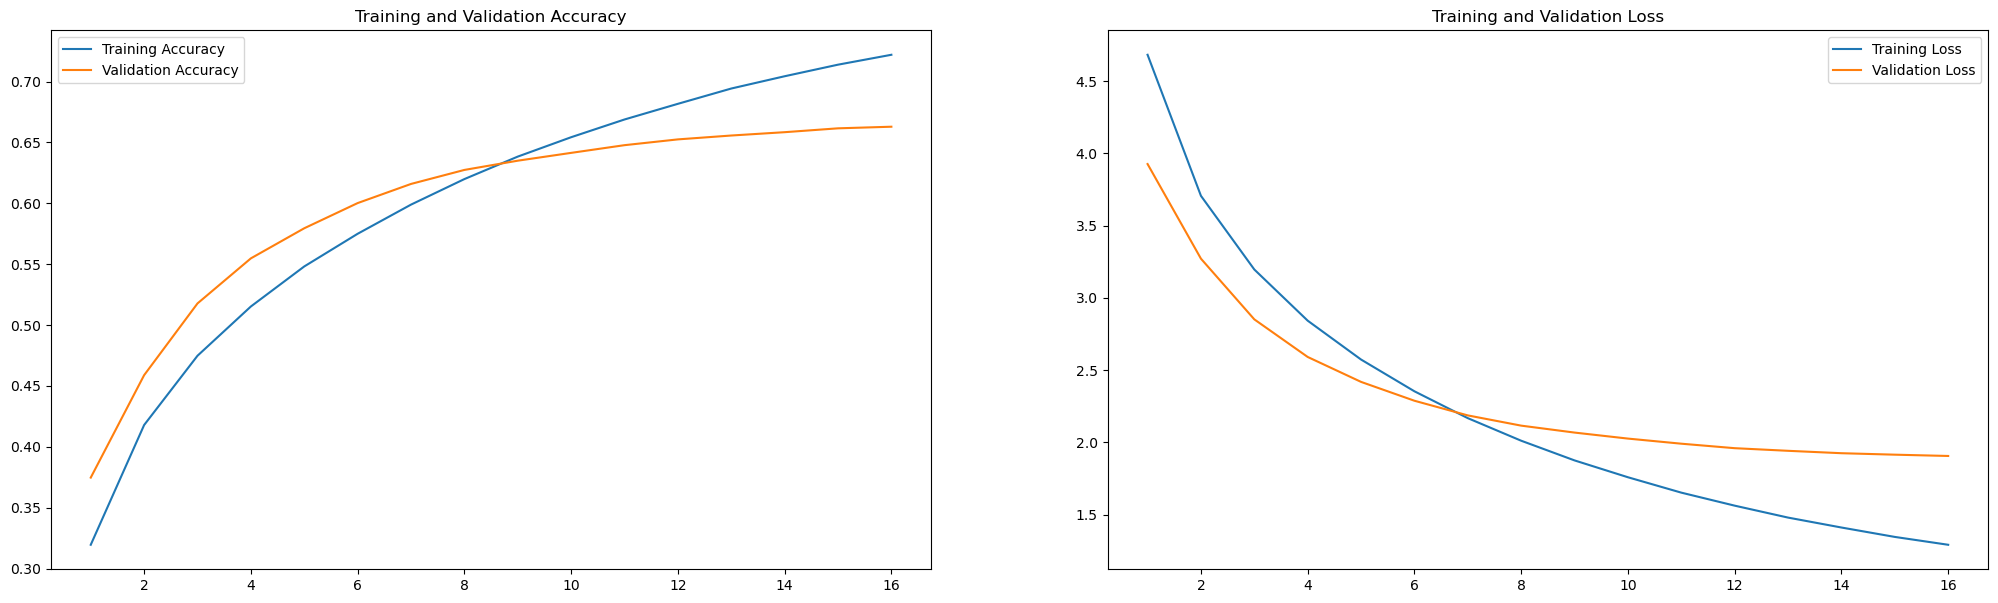

In [15]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range( 1, len(accuracy) + 1)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(25,7))

ax[0].plot(epochs, accuracy, label='Training Accuracy')
ax[0].plot(epochs, val_acc, label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, label='Training Loss')
ax[1].plot(epochs, val_loss, label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend();

### Translating some sentences

In [20]:
test_model = keras.models.load_model('sequence2sequence_rnn.keras')

In [32]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))

max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    
    decoded_sentence = "[start]"
    
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        
        # next_token_predictions = sequecen2sequence_rnn.predict(
        #     [tokenized_input_sentence, tokenized_target_sentence]
        # )
        
        next_token_predictions = test_model.predict(
            [tokenized_input_sentence, tokenized_target_sentence]
        )
        
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        
        sampled_token = spa_index_lookup[sampled_token_index]
        
        decoded_sentence += " " + sampled_token
        
        if sampled_token == "[end]":
            break
            
    return decoded_sentence        

In [34]:
te_eng_texts = [pair[0] for pair in te_pairs]

for _ in range(7):
    input_sentence = random.choice(te_eng_texts)
    
    print("_")
    print(input_sentence)
    print(decode_sequence(input_sentence))

_
Tom is a lot older than Mary.
1/1 [==============================] - 0s 23ms/step
[start] tom es mucho más joven que mary [end]
_
Tom asked Mary if she knew when the concert started.
1/1 [==============================] - 0s 24ms/step
[start] tom le preguntó a mary si conocía el concierto [end]
_
I really missed you when you were in France.
1/1 [==============================] - 0s 24ms/step
[start] me gustan cuando te gustan los estados unidos [end]
_
Why did you tell Tom that you don't know me?
1/1 [==============================] - 0s 25ms/step
[start] por qué le dijiste a tom que no lo [UNK] [end]
_
Stand up!
1/1 [==============================] - 0s 21ms/step
[start] [UNK] [end]
_
You've got a fever.
1/1 [==============================] - 0s 23ms/step
[start] tienes fiebre [end]
_
He was awarded a special prize.
1/1 [==============================] - 0s 23ms/step
[start] Él fue un [UNK] [UNK] [end]
